In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
# Add the path to the utils directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
from import_funcs import * #list_files_with_extension, extract_data_inline
import matplotlib.pyplot as plt
import numpy as np

In [5]:
path = './data'
txt_files = list_files_with_extension(path, '.txt')

# Add a 'time_index' column before concatenating all_X
all_X = []

for file in txt_files:
    # # Extract condition (text after last underscore, before .txt)
    # condition = Path(file).stem.split(' ')[-1]
    # Extract data
    idx_start, idx_stop, delta_time, T, X_local = extract_data_inline(file)
    # Drop unwanted columns
    X_local = X_local.drop(columns=['power'])
    # Add time_index column
    X_local = X_local.copy()
    X_local['time_index'] = X_local.index
    # # Add condition column
    # X_local['condition'] = condition
    all_X.append(X_local)

all_X = pd.concat(all_X, ignore_index=True)

In [8]:
# Assign 'antenna_length' labels for each measurement separately
all_X['antenna_length'] = None

cond_df = all_X.copy()
cooling_periods = cond_df[cond_df['cooling_flag_1'] == 1].copy()
cooling_periods['group'] = (cooling_periods['time_index'].diff() != 1).cumsum()
periods = cooling_periods.groupby('group')['time_index'].agg(['first', 'last']).reset_index(drop=True)
# Use labels list, repeat if needed
lengths = [10 + 5*i for i in range(5)]

length_labels = lengths * ((len(periods) + len(lengths) - 1) // len(lengths))

periods['antenna_length'] = length_labels[:len(periods)]
for _, row in periods.iterrows():
    mask = (all_X['time_index'] >= row['first']) & (all_X['time_index'] <= row['last'])
    all_X.loc[mask, 'antenna_length'] = row['antenna_length']

print(all_X['antenna_length'].value_counts(dropna=False))

antenna_length
None    376
25       75
10       69
30       67
15       64
20       64
Name: count, dtype: int64


In [ ]:
# Remove rows where antenna_length is None
all_X = all_X[all_X['antenna_length'].notna()].copy()

In [13]:
# Create a new time index with 20-second gaps between antenna lengths
gap_duration = 20  # seconds between each antenna length
length_labels = [10, 15, 20, 25, 30]  # Use the defined antenna lengths

# Initialize time_index_2 column
all_X['time_index_2'] = 0.0
current_time = 0

for l in length_labels:
    # Get data for this antenna length
    length_data = all_X[all_X['antenna_length'] == l].copy()
    
    if len(length_data) > 0:
        # Sort by original time_index to maintain chronological order
        length_data = length_data.sort_values('time_index')
        
        # Create new continuous time index for this antenna length
        duration = len(length_data)
        new_time_indices = np.arange(current_time, current_time + duration)
        
        # Update the main dataframe
        mask = all_X['antenna_length'] == l
        all_X.loc[mask, 'time_index_2'] = new_time_indices
        
        # Update current_time for next antenna length (add duration + gap)
        current_time += duration + gap_duration
        
        print(f"Antenna length {l}: {len(length_data)} data points, time range: {new_time_indices[0]:.1f} - {new_time_indices[-1]:.1f} s")

print(f"\nTotal duration: {current_time - gap_duration:.1f} seconds")

Antenna length 10: 69 data points, time range: 0.0 - 68.0 s
Antenna length 15: 64 data points, time range: 89.0 - 152.0 s
Antenna length 20: 64 data points, time range: 173.0 - 236.0 s
Antenna length 25: 75 data points, time range: 257.0 - 331.0 s
Antenna length 30: 67 data points, time range: 352.0 - 418.0 s

Total duration: 419.0 seconds


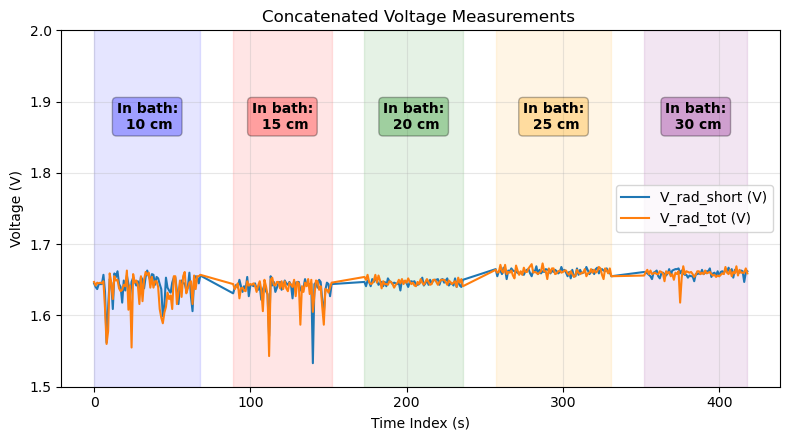

In [21]:
# Plot all data using the new concatenated time index
plt.figure(figsize=(8, 4.5))

# Define colors for each class
class_colors = {
    10: 'blue',
    15: 'red', 
    20: 'green',
    25: 'orange',
    30: 'purple'
}

# Plot each voltage variable
variables = ['V_rad_short', 'V_rad_tot', 'V_housing']
variables = ['V_rad_short', 'V_rad_tot']
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_spike': 'V_spike (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)'
}

# Sort data by time_index_2 for proper plotting
data_sorted = all_X.sort_values('time_index_2')

for var in variables:
    plt.plot(data_sorted['time_index_2'], data_sorted[var] / 1000, label=labels[var])

plt.ylim(1.5, 2)

# Add vertical lines to separate classes and color-code background
class_boundaries = []
current_pos = 0

for l in length_labels:
    data = all_X[all_X['antenna_length'] == l]
    if len(data) > 0:
        start = data['time_index_2'].min()
        end = data['time_index_2'].max()

        # Add background color for each class
        plt.axvspan(start, end, alpha=0.1, color=class_colors[l], label=f'{l} region')


        # Add text annotation for class name
        class_center = (start + end) / 2
        plt.text(class_center, plt.ylim()[1] * 0.95, f"In bath:\n {l} cm", 
                ha='center', va='top', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=class_colors[l], alpha=0.3))

plt.title("Concatenated Voltage Measurements ")
plt.xlabel("Time Index (s)")
plt.ylabel("Voltage (V)")
plt.grid(True, alpha=0.3)

# Create legend with voltage variables only (avoid duplicate region labels)
voltage_handles = [plt.Line2D([0], [0], color=plt.gca().get_lines()[i].get_color(), 
                             label=labels[var]) 
                  for i, var in enumerate(variables)]
plt.legend(handles=voltage_handles, loc='right')

plt.tight_layout()
plt.show()

# # Print summary
# print("\nData summary by class:")
# for class_name in class_order:
#     class_data = all_X[all_X['class'] == class_name]
#     if len(class_data) > 0:
#         time_range = f"{class_data['time_index_2'].min():.1f} - {class_data['time_index_2'].max():.1f} s"
#         print(f"{class_name}: {len(class_data)} points, time range: {time_range}")

### Calculate T_tissue with calibration V3 parameters

In [32]:
# Define calibration parameters as variables
RadSlopeChange = 0.0006182511106682944  # V/°C²
RadSlope0 = -0.06051481175395883        # V/°C
RadOffsetChange = -0.0009632383570051569 # V/°C
RadOffset0 = 0.2300154917793174         # V
HousingSlope = 98.08555780332561        # °C/V
HousingOffset = -49.81626782454236      # °C

AL = 0.36  # Measured Antenna loss
CL = 0.44  # Measured Cable loss


In [33]:
from calibration_funcs import * 
all_X["T_housing"] = T_housing_func(all_X["V_housing"]/1000, HousingSlope, HousingOffset)
all_X["T_rad"] = T_rad_func(all_X["V_rad_short"]/1000, all_X["T_housing"], RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)
all_X["T_tissue"] = T_tissue_antenna_func(all_X["T_rad"], 50, AL)

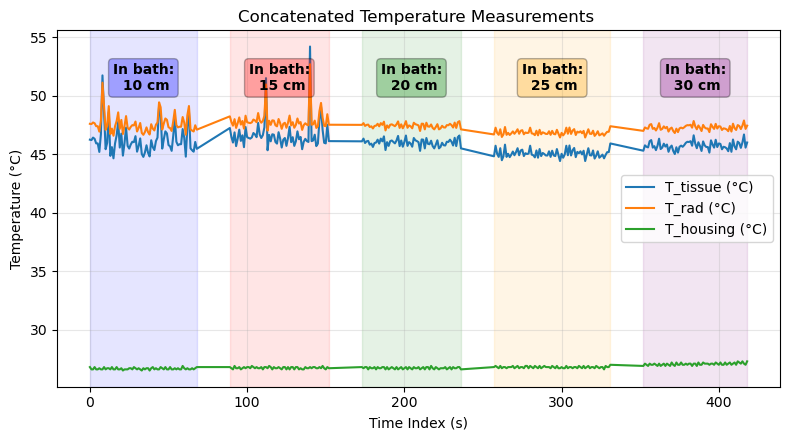

In [ ]:
# Plot all data using the new concatenated time index
plt.figure(figsize=(8, 4.5))

# Define colors for each class
class_colors = {
    10: 'blue',
    15: 'red', 
    20: 'green',
    25: 'orange',
    30: 'purple'
}

# Plot each temperature variable
variables = ['T_tissue', 'T_rad', 'T_housing']
labels = {
    'T_tissue': 'T_tissue (°C)',
    'T_rad': 'T_rad (°C)',
    'T_housing': 'T_housing (°C)',
}

# Sort data by time_index_2 for proper plotting
data_sorted = all_X.sort_values('time_index_2')

for var in variables:
    plt.plot(data_sorted['time_index_2'], data_sorted[var], label=labels[var])

# Add vertical lines to separate classes and color-code background
class_boundaries = []
current_pos = 0

for l in length_labels:
    data = all_X[all_X['antenna_length'] == l]
    if len(data) > 0:
        start = data['time_index_2'].min()
        end = data['time_index_2'].max()

        # Add background color for each class
        plt.axvspan(start, end, alpha=0.1, color=class_colors[l], label=f'{l} region')


        # Add text annotation for class name
        class_center = (start + end) / 2
        plt.text(class_center, plt.ylim()[1] * 0.95, f"In bath:\n {l} cm", 
                ha='center', va='top', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=class_colors[l], alpha=0.3))

plt.title("Concatenated Temperature Measurements ")
plt.xlabel("Time Index (s)")
plt.ylabel("Temperature (°C)")
plt.grid(True, alpha=0.3)

# Create legend with voltage variables only (avoid duplicate region labels)
voltage_handles = [plt.Line2D([0], [0], color=plt.gca().get_lines()[i].get_color(), 
                             label=labels[var]) 
                  for i, var in enumerate(variables)]
plt.legend(handles=voltage_handles, loc='right')

plt.tight_layout()
plt.show()

In [42]:
def T_tissue_antenna_refinded(T_rad, T_antenna_in_bath, T_antenna_outside, propor_antenna_in_bath, AL):
    S21_dB = 10 * np.log10(1-AL)
    S21_in_bath = S21_dB*(np.array(propor_antenna_in_bath))
    S21_outside = S21_dB*(1-np.array(propor_antenna_in_bath))
    AL_in_bath = 1-10**(S21_in_bath/10)
    AL_outside = 1-10**(S21_outside/10)
    print(propor_antenna_in_bath, 1-AL, (1-AL_in_bath)*(1-AL_outside),AL_in_bath, AL_outside)
    return (np.array(T_rad) - T_antenna_in_bath*AL_in_bath*(1-AL_outside)- T_antenna_outside*AL_outside) / ((1-AL_in_bath)*(1-AL_outside))


In [45]:
AL

0.36

In [56]:
AL = 0.36  # Measured Antenna loss
for l, group in all_X.groupby("antenna_length"):
    # Calculate T_tissue for each antenna length group
    T_tissue = T_tissue_antenna_refinded(group["T_rad"], 50, 26, l / 40, AL)
    all_X.loc[group.index, "T_tissue"] = T_tissue

0.25 0.64 0.64 0.10557280900008414 0.2844582472000673
0.375 0.64 0.64 0.15410298924754873 0.2434067127974593
0.5 0.64 0.6400000000000001 0.19999999999999996 0.19999999999999996
0.625 0.64 0.64 0.2434067127974593 0.15410298924754873
0.75 0.64 0.64 0.2844582472000673 0.10557280900008414


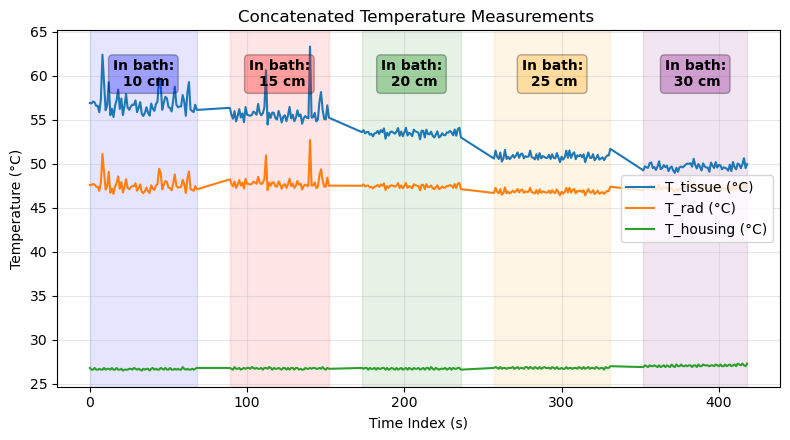

In [57]:
# Plot all data using the new concatenated time index
plt.figure(figsize=(8, 4.5))

# Define colors for each class
class_colors = {
    10: 'blue',
    15: 'red', 
    20: 'green',
    25: 'orange',
    30: 'purple'
}

# Plot each temperature variable
variables = ['T_tissue', 'T_rad', 'T_housing']
labels = {
    'T_tissue': 'T_tissue (°C)',
    'T_rad': 'T_rad (°C)',
    'T_housing': 'T_housing (°C)',
}

# Sort data by time_index_2 for proper plotting
data_sorted = all_X.sort_values('time_index_2')

for var in variables:
    plt.plot(data_sorted['time_index_2'], data_sorted[var], label=labels[var])

# Add vertical lines to separate classes and color-code background
class_boundaries = []
current_pos = 0

for l in length_labels:
    data = all_X[all_X['antenna_length'] == l]
    if len(data) > 0:
        start = data['time_index_2'].min()
        end = data['time_index_2'].max()

        # Add background color for each class
        plt.axvspan(start, end, alpha=0.1, color=class_colors[l], label=f'{l} region')


        # Add text annotation for class name
        class_center = (start + end) / 2
        plt.text(class_center, plt.ylim()[1] * 0.95, f"In bath:\n {l} cm", 
                ha='center', va='top', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=class_colors[l], alpha=0.3))

plt.title("Concatenated Temperature Measurements ")
plt.xlabel("Time Index (s)")
plt.ylabel("Temperature (°C)")
plt.grid(True, alpha=0.3)

# Create legend with voltage variables only (avoid duplicate region labels)
voltage_handles = [plt.Line2D([0], [0], color=plt.gca().get_lines()[i].get_color(), 
                             label=labels[var]) 
                  for i, var in enumerate(variables)]
plt.legend(handles=voltage_handles, loc='right')

plt.tight_layout()
plt.show()